# Example: Mixed-Element Mesh for Delineated Watershed

This workflow provides a complete working example to develop an mixed-element mesh for Coweeta watershed. Long quad elements with pentagons at junctions are placed along NHDPlus flowlines to represent rivers/streams. Rest of the domain is meshed with standard TIN.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

This workflow creates the following files:

* Mesh file: `Coweeta.exo`, includes all labeled sets


In [1]:
## Importing all the package needed to run teh watershed workflow
# conda package imports
import os,sys
import numpy as np
import pandas
from matplotlib import pyplot as plt
import shapely
import logging
import pandas as pd
import fiona
import copy
import scipy

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.condition
import watershed_workflow.densify_rivers_hucs
import watershed_workflow.create_river_mesh
watershed_workflow.ui.setup_logging(1,None)

In [2]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
coweeta_shapefile = './Coweeta/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
name = 'Coweeta'
modis_name = None

figsize = (6,6)
figsize_3d = (8,6)

# Geomtric parameters tuning the degree of cleaning of the raw data and scales of hydrologic features to be considered
simplify = 60 # length scale to target average edge
ignore_small_rivers = 2 
prune_by_area_fraction = 0.01 

# huc boundary refinement control
refine_d0 = 20
refine_d1 = 100
refine_L0 = 70
refine_L1 = 200

In [3]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [4]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = watershed_workflow.source_list.dem_sources['NED 1/3 arc-second']
watershed_workflow.source_list.log_sources(sources)

2023-02-03 17:03:58,336 - root - INFO: Using sources:
2023-02-03 17:03:58,337 - root - INFO: --------------
2023-02-03 17:03:58,338 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-02-03 17:03:58,339 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-02-03 17:03:58,340 - root - INFO: DEM: National Elevation Dataset (NED)
2023-02-03 17:03:58,340 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2023-02-03 17:03:58,341 - root - INFO: geologic structure: GLHYMPS version 2.0
2023-02-03 17:03:58,341 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2023-02-03 17:03:58,342 - root - INFO: lai: MODIS
2023-02-03 17:03:58,342 - root - INFO: soil thickness: None
2023-02-03 17:03:58,343 - root - INFO: meteorology: DayMet 1km


### Get HUCs

In [5]:
# load hucs from shape
_, watershed = watershed_workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)

2023-02-03 17:03:58,348 - root - INFO: 
2023-02-03 17:03:58,350 - root - INFO: Loading shapes
2023-02-03 17:03:58,351 - root - INFO: ------------------------------
2023-02-03 17:03:58,351 - root - INFO: Loading file: './Coweeta/input_data/coweeta_basin.shp'
2023-02-03 17:03:58,370 - root - INFO: ... found 1 shapes
2023-02-03 17:03:58,371 - root - INFO: Converting to shapely
2023-02-03 17:03:58,376 - root - INFO: Converting to requested CRS


### Get Rivers 

In [7]:
include_rivers=True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], hint, 
                                                watershed.exterior(), crs, crs,
                                                in_network=True, properties=True)
    
    rivers = watershed_workflow.construct_rivers(watershed, reaches, method='hydroseq',
                                                 ignore_small_rivers=ignore_small_rivers,
                                                 prune_by_area_fraction=prune_by_area_fraction,
                                                 remove_diversions=True,
                                                 remove_braided_divergences=True)
    
    # keeping the originals
    rivers_orig=[river.deep_copy() for river in rivers]
    watershed_orig=copy.deepcopy(watershed) 
    
    # simplifying 
    rivers_orig = watershed_workflow.simplify(watershed_orig, rivers_orig, simplify_hucs=1, simplify_rivers=1,
                               snap_rivers=True, cut_intersections=True)
    
    rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                               snap_rivers=True, cut_intersections=True)
    
    # for plotting purpose only
    rivers_simplified=[river.deep_copy() for river in rivers] 
    watershed_simplified=copy.deepcopy(watershed) 

else:
    reaches = []
    rivers = []

2023-02-03 17:04:23,926 - root - INFO: 
2023-02-03 17:04:23,927 - root - INFO: Loading Hydrography
2023-02-03 17:04:23,928 - root - INFO: ------------------------------
2023-02-03 17:04:23,929 - root - INFO: Loading streams in HUC 0601
2023-02-03 17:04:23,930 - root - INFO:          and/or bounds (1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)
2023-02-03 17:04:23,933 - root - INFO:   Using Hydrography file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2023-02-03 17:04:23,934 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)'
2023-02-03 17:04:25,321 - root - INFO:   Found total of 44 in bounds.
2023-02-03 17:04:25,323 - root - INFO:   Filtering reach

Original watershed and river trees are kept for resampling at a desired resolution in the final watershed and rivertree

### Plotting original and simplified-pruned rivers and watershed


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_DEV-2022-08-29/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


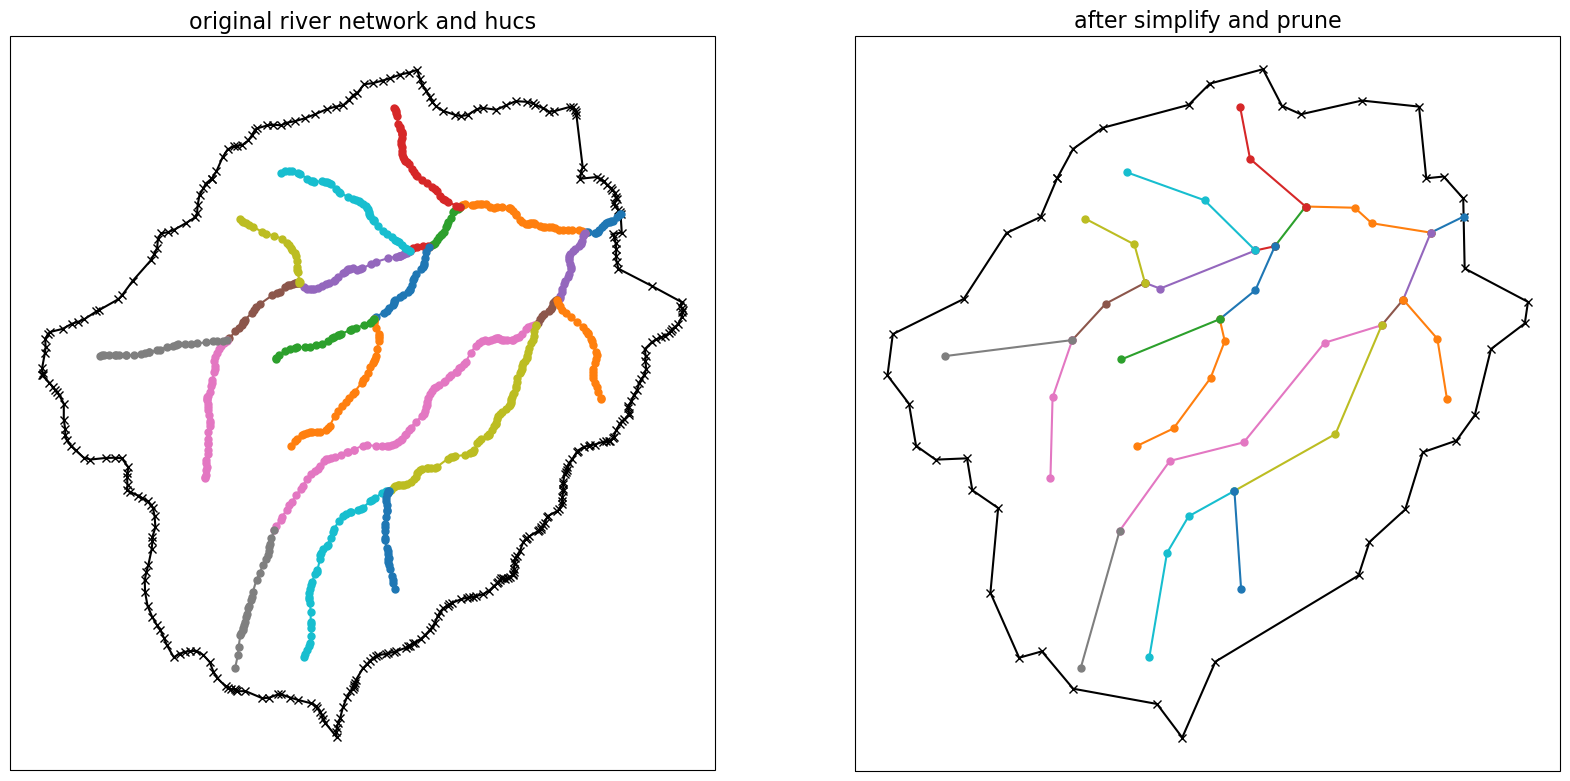

In [8]:
plt.rcParams['figure.figsize'] = [20, 20]

fig, axs = plt.subplots(1,2,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})

axs[0].plot(watershed_orig.exterior().exterior.xy[0], watershed_orig.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=5)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=5)

### Densification of River Network and Watershed

In [9]:
d0 = refine_d0; d1 = refine_d1
L0 = refine_L0; L1 = refine_L1 

#densify_watershed
watershed=watershed_workflow.densify_rivers_hucs.densify_hucs(watershed, watershed_orig, rivers, use_original=True, limit_scales=[d0,L0,d1,L1]) 

#densify_river
rivers=watershed_workflow.densify_rivers_hucs.densify_rivers(rivers, rivers_orig, limit=70, use_original=True, treat_collinearity=False)

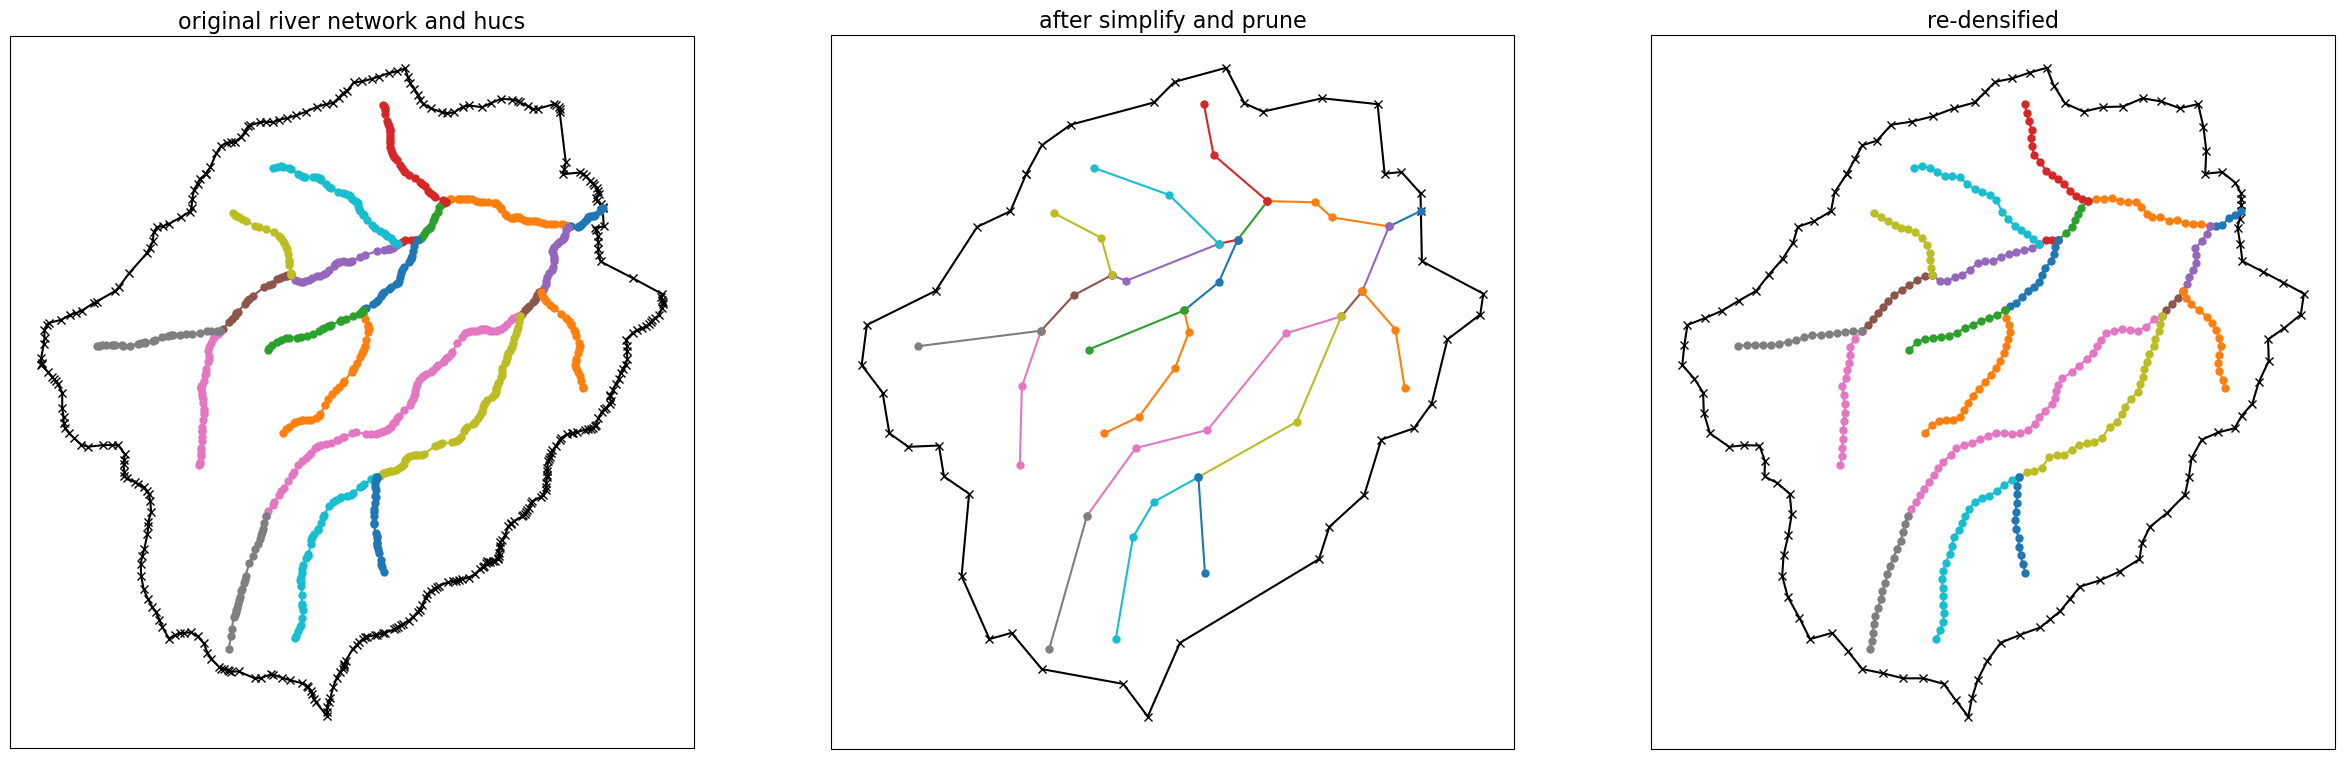

In [10]:
# comparing original, simplified and re-densified huc and river
plt.rcParams['figure.figsize'] = [30, 20]

fig, axs = plt.subplots(1,3,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})

axs[0].plot(watershed_orig.exterior().exterior.xy[0], watershed_orig.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed_simplified.exterior().exterior.xy[0], watershed_simplified.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)
axs[2].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[2].set_title('re-densified',fontsize=16)
axs[2].plot()

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=5)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=5)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[2].plot(x,y,'-o',markersize=5)

In [11]:
# Printing order of streams and their NHDPLus IDs
# for node in river_densified.preOrder():
#    print(node.properties['StreamOrder'],node.properties['NHDPlusID'])

## Meshing Begin

### Creating River Corridor

In [12]:
## This is a combined function of the above four steps. 
widths = dict({1:8,2:12,3:16}) 
quads, corrs=watershed_workflow.create_river_mesh.create_rivers_meshes(rivers=rivers, widths=dict({1:8,2:12,3:16}), enforce_convexity=True)

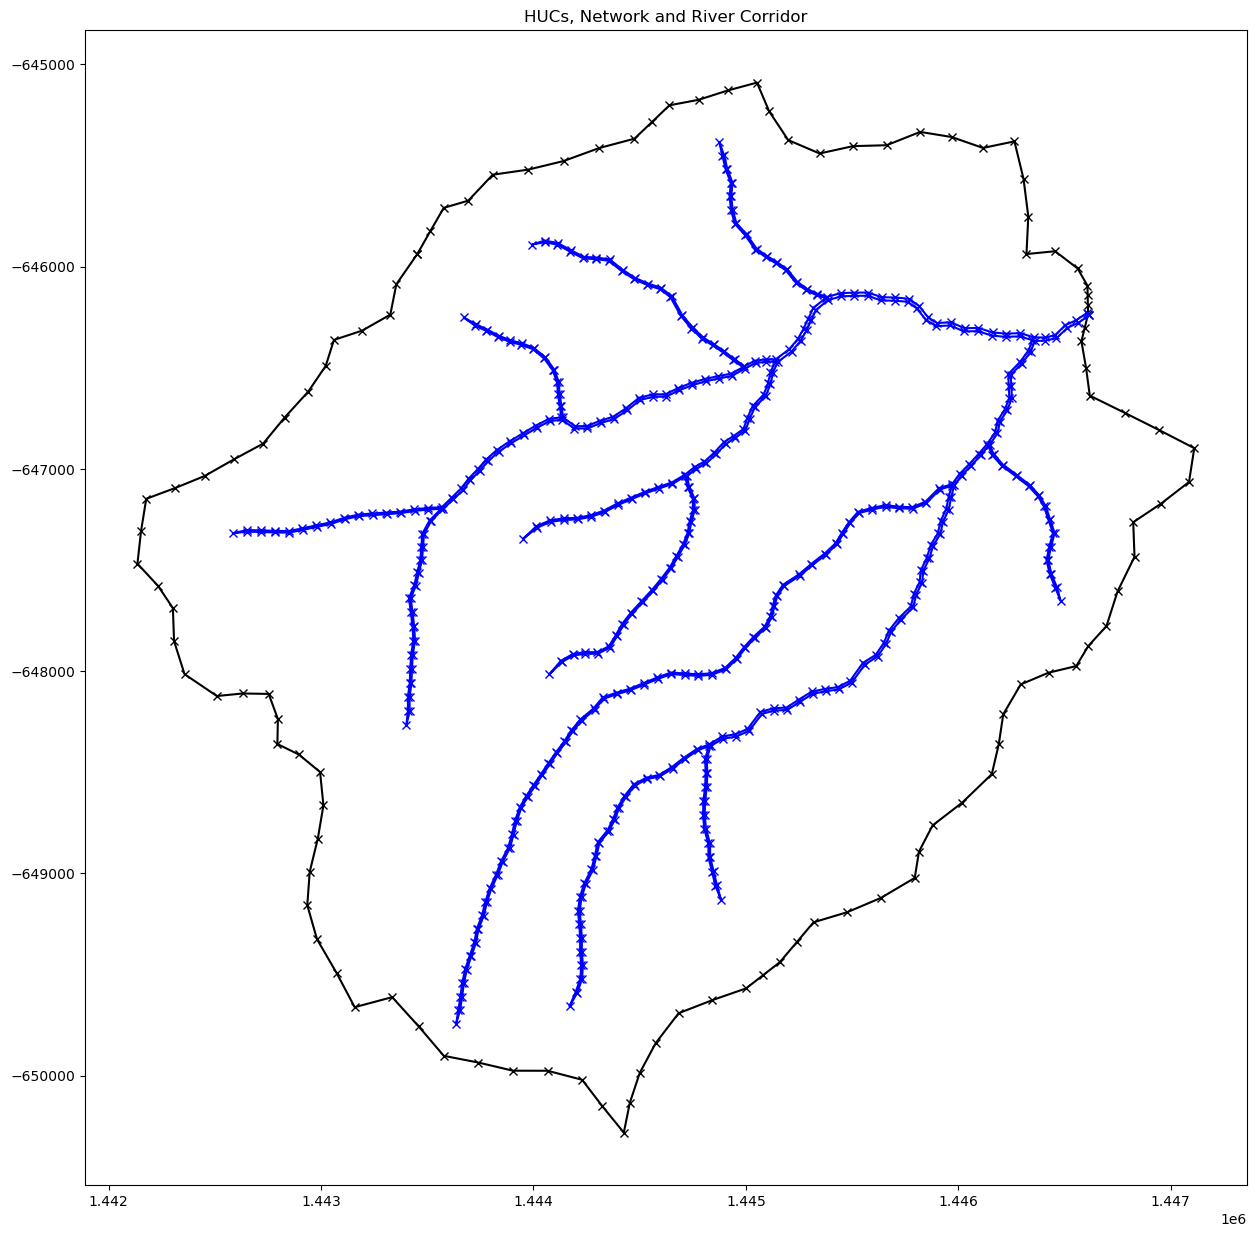

In [13]:
## plotting river corridor and huc
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
for corr in corrs:   
    ax.plot(corr.exterior.xy[0], corr.exterior.xy[1], 'b-x')
plt.title('HUCs, Network and River Corridor')
plt.show()

In [16]:
points, elems= watershed_workflow.triangulate(watershed, rivers, None,
                                              corrs, 
                                              refine_min_angle=32,
                                              refine_max_area=30000,
                                              diagnostics=False, tol=0.1)

2023-02-03 17:05:00,267 - root - INFO: 
2023-02-03 17:05:00,269 - root - INFO: Meshing
2023-02-03 17:05:00,270 - root - INFO: ------------------------------
2023-02-03 17:05:00,282 - root - INFO: Triangulating...
2023-02-03 17:05:00,283 - root - INFO: Adding river-corridor outlet into huc boundary
2023-02-03 17:05:00,288 - root - INFO:    747 points and 748 facets
2023-02-03 17:05:00,289 - root - INFO:  checking graph consistency
2023-02-03 17:05:00,290 - root - INFO:  tolerance is set to 0.1
2023-02-03 17:05:00,296 - root - INFO:  building graph data structures
2023-02-03 17:05:00,301 - root - INFO: defining hole..
2023-02-03 17:05:00,309 - root - INFO:  triangle.build...
2023-02-03 17:05:00,332 - root - INFO:   ...built: 1750 mesh points and 2751 triangles


maximum area of the traingle 29715.954773 , minimum area of the triangle 818.832458 , number of triangles 2751


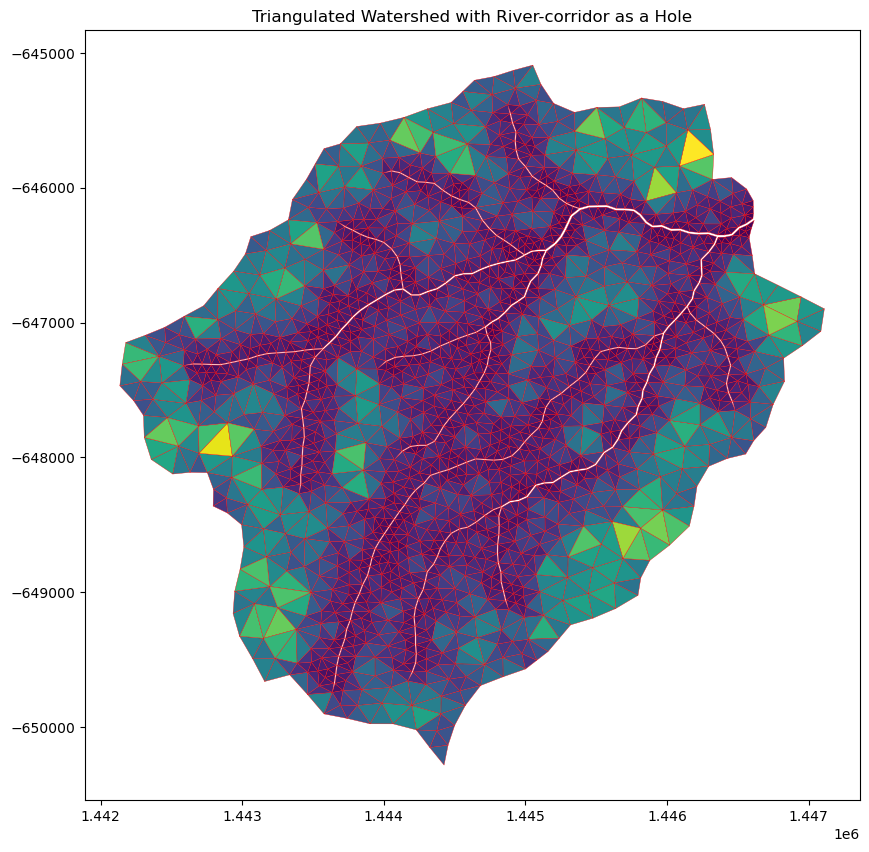

In [17]:
areas = np.array([watershed_workflow.utils.triangle_area(points[e]) for e in elems])
print('maximum area of the traingle', round(max(areas),6) ,', minimum area of the triangle', round(min(areas),6), ', number of triangles', len(areas))
plt.rcParams['figure.figsize'] = [10, 10]
plt.tripcolor(points[:,0], points[:,1], elems, areas, edgecolor='r')
plt.title('Triangulated Watershed with River-corridor as a Hole')

plt.show()

In [18]:
# merging the list of river elenents with the triangulated mesh
elems_list=[elem.tolist() for elem in list(elems)]
for elem in quads:
    elems_list.append(elem)

In [19]:
# download the needed rasters
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2023-02-03 17:05:07,318 - root - INFO: 
2023-02-03 17:05:07,319 - root - INFO: Loading Raster
2023-02-03 17:05:07,320 - root - INFO: ------------------------------
2023-02-03 17:05:07,322 - root - INFO: Collecting raster
2023-02-03 17:05:07,335 - root - INFO: Collecting DEMs to tile bounds: [-83.48845037186388, 35.01734099944037, -83.41165773504302, 35.08381933600275]
2023-02-03 17:05:07,341 - root - INFO:   Need:
2023-02-03 17:05:07,342 - root - INFO:     /Users/uec/code/watershed_workflow/data-library/dem/USGS_NED_13as_n36_w084.tif
2023-02-03 17:05:09,263 - root - INFO: https://tnmaccess.nationalmap.gov/api/v1/products?datasets=National+Elevation+Dataset+%28NED%29+1%2F3+arc-second&bbox=-83.48845037186388%2C35.01734099944037%2C-83.41165773504302%2C35.08381933600275&prodFormats=GeoTIFF
2023-02-03 17:05:09,265 - root - INFO: Attempting to download source for target '/Users/uec/code/watershed_workflow/data-library/dem/USGS_NED_13as_n36_w084.tif'
2023-02-03 17:05:09,268 - root - INFO: Dow

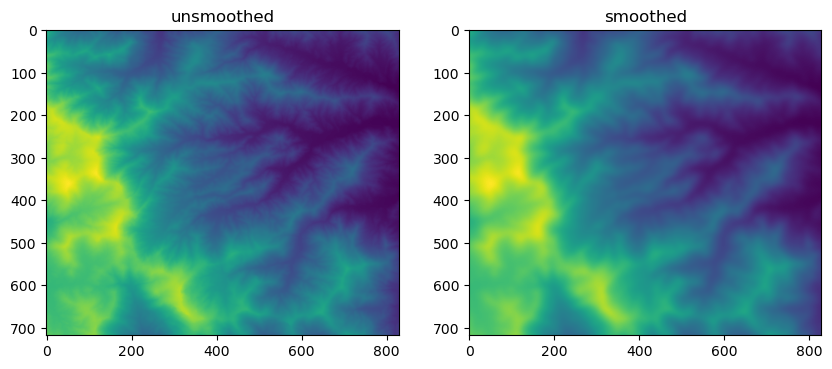

In [20]:
# noting that the DEM is a 30m raster, and we want to run at a coarser resolution of ~100-300m, 
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
dem_sm = scipy.ndimage.gaussian_filter(dem, 5, mode='nearest')
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(dem)
axs[0].set_title('unsmoothed')
axs[1].imshow(dem_sm)
txt = axs[1].set_title('smoothed')

In [21]:
crs = watershed_workflow.crs.daymet_crs()
mesh_points3 = watershed_workflow.elevate(points, crs, dem, dem_profile)

2023-02-04 20:30:37,096 - root - INFO: 
2023-02-04 20:30:37,098 - root - INFO: Elevating Triangulation to DEM
2023-02-04 20:30:37,099 - root - INFO: ------------------------------


In [22]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), elems_list)

kwargs =  {'linewidth': 0.5, 'cmap': <matplotlib.colors.ListedColormap object at 0x165149c90>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x164f4db40>, 'edgecolor': 'k', 'linestyle': '-'}
setting face color =  [1343.96138547 1340.4860078   780.08036173 ...  869.46300841  883.70943386
  894.41435393]


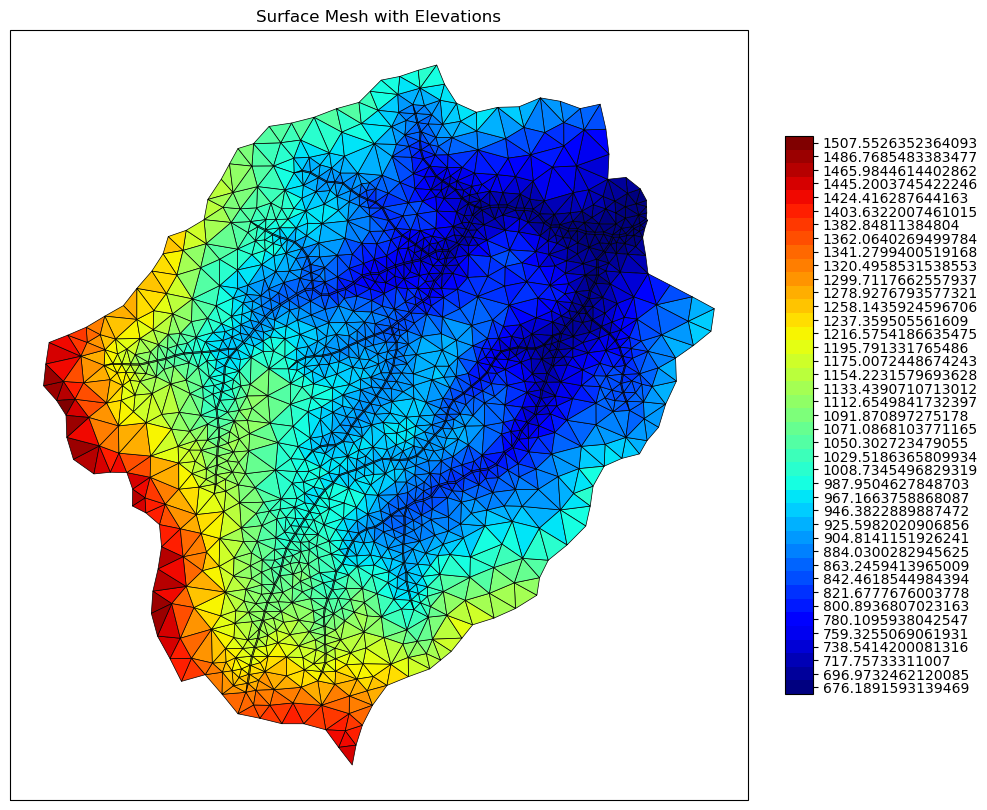

In [23]:
# plotting surface mesh with elevations
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)
fig.set_size_inches(12, 10)
plt.rcParams['figure.figsize'] = [10, 10]
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.5 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')

watershed_workflow.colors.colorbar_index(ncolors=len(legend_values), cmap=cmap, labels = labels) 
plt.title('Surface Mesh with Elevations')
plt.show()

In [24]:
# adding elevations to the river tree for stream bed conditioning

# for river in rivers:
#     for i, node in enumerate(river.preOrder()):
#             node_points=(np.array(node.segment.xy).T)
#             node_elevs = watershed_workflow.elevate(node_points, crs, dem, dem_profile)[:,2] 
#             assert(len(node_elevs)==len(node.segment.coords))
#             node.properties['elev_profile']=node_elevs

In [25]:
#watershed_workflow.condition.condition_river_mesh(m2, river, cut_off_order=6)

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed forest.

In [26]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = watershed_workflow.values_from_raster(m2.centroids, crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2023-02-04 20:30:45,394 - root - INFO: 
2023-02-04 20:30:45,395 - root - INFO: Loading Raster
2023-02-04 20:30:45,396 - root - INFO: ------------------------------
2023-02-04 20:30:45,397 - root - INFO: Collecting raster
2023-02-04 20:30:45,605 - root - INFO: ... got raster of shape: (180, 173)
2023-02-04 20:30:45,689 - root - INFO: ... got raster bounds: (1129275.0, 1410015.0, 1134465.0, 1404615.0)
2023-02-04 20:30:45,803 - root - INFO: Found land cover dtypes: uint8
2023-02-04 20:30:45,804 - root - INFO: Found land cover types: {41, 42, 43, 81, 52, 21, 22}


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_DEV-2022-08-29/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x164e8b100>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x164e8a8f0>, 'edgecolor': 'none', 'linewidth': 0.5, 'linestyle': '-'}
setting face color =  [41 21 41 ... 42 42 41]


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (8).

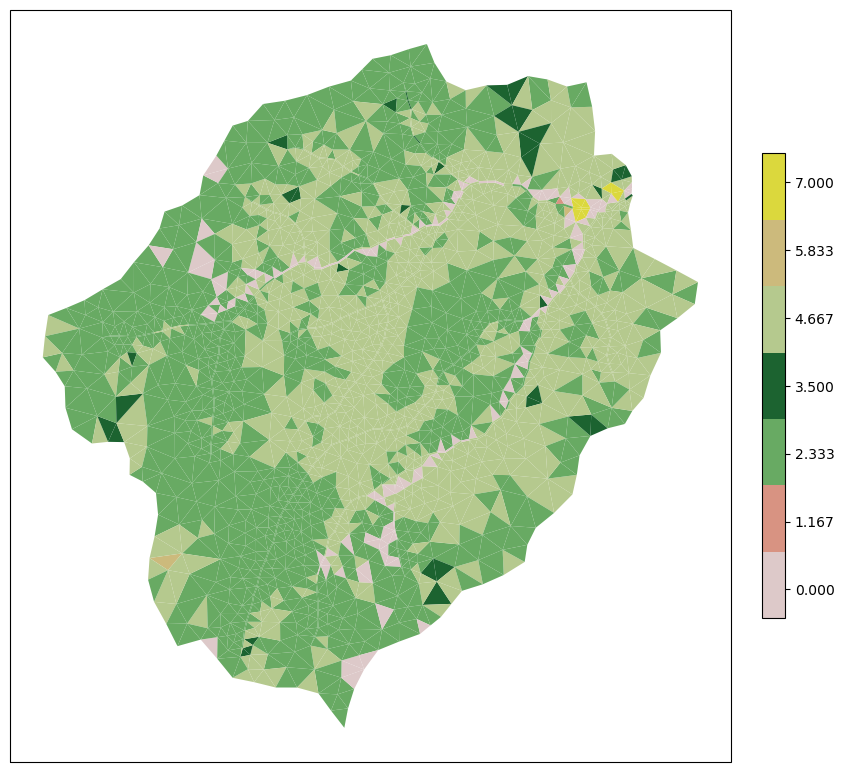

In [27]:
# plot the image
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
            watershed_workflow.colors.generate_nlcd_colormap(lc)

fig, ax = watershed_workflow.plot.get_ax(crs)
polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                 facecolor='color', linewidth=0.5)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")

nlcd_indices


## Subsurface properties

The default model uses GLHYMPS to identify geologic formations, and 

In [ ]:
# download the NRCS soils data as shapes and project it onto the mesh
#
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], list(watershed.polygons()), crs, 
                                                     crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = list(soil_survey_props['mukey'][:])
soil_survey_props.set_index('mukey', inplace=True)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    watershed.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)
soil_survey_props

Select only the soils within the watershed

In [28]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

NameError: name 'soil_color' is not defined

In [29]:
# what does soil thickness look like?
soil_thickness = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

soil_thickness = soil_thickness / 100
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_thickness, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0.5, color=soil_thickness, 
                        cmap=cmap                       )
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
#watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_thickness))//10, cmap=cmap, labels = labels) 
ax.axis('off')
plt.tight_layout()
print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))
plt.show()


NameError: name 'soil_color' is not defined

In [ ]:
# plot of porosity from SSURGO
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(iprop, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0.5, color=iprop, cmap=cmap, facecolor='color')
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
ax.axis('off')
plt.tight_layout()
print('Median porosity [-] = ', np.nanmedian(iprop))

In [ ]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']
    
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(np.log10(iprop), cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0,color=np.log10(iprop),cmap=cmap, facecolor='color')
ax.set_title('soil permeability [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')
print('Min k [m^2] = ', np.nanmin(iprop))

In [ ]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
soil_survey_props_clean = soil_survey_props.reset_index()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)


def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)
    
# drop nans
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)

soil_survey_props_clean


In [ ]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukey in enumerate(soil_survey_props_clean['native_index']):
    soil_color_new[np.where(soil_color == mukey)] = 1000+new_id
 

# image the new soil_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                    linewidth=0, color=soil_color_new, 
                    cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.  Instead we rely on scaling laws to fill the data.

In [ ]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = watershed_workflow.get_shapes(sources['geologic structure'], 
                                                      target_bounds, crs, crs, properties=True)

# -- log the bounds targeted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)



In [ ]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

In [ ]:
# plot the geologic formation id
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color, cmap='tab20b')

fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                    linewidth=0, color=geo_color, 
                    cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels=labels) 

ax.set_title('geol type index')
ax.axis('off')

In [ ]:
# plot permeability of the underlying geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
    
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(np.log10(iprop), cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0.5,color=np.log10(iprop),cmap=cmap, facecolor='color')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')


In [ ]:
# plot porosity of the geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'porosity [-]']

indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(iprop, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0.5,color=np.log10(iprop),cmap=cmap, facecolor='color')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology porosity [-]')
ax.axis('off')


In [ ]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)


def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
geo_survey_props_clean

In [ ]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                    linewidth=0, color=geo_color_new, 
                    cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [ ]:
DTB_source = watershed_workflow.source_list.FileManagerSoilGrids2017()
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(DTB_source, watershed.exterior(), crs, 
                                                       nodata=-99999, variable='BDTICM')

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)


In [ ]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(DTB, cmap='plasma_r')
mp = watershed_workflow.plot.mesh(m2, crs, ax=ax,
                        linewidth=0,color=DTB,cmap=cmap, facecolor='color')
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')

## A combined, complete product?

As a default, we would like a material-driven (e.g. not fields for porosity, perm, etc, but soil classes, each with a common porosity/permeability/vG curve) default that is valid everywhere.  That makes it clear that we must rely on GLHYMPS as the only material-based product that is valid everywhere.  Other products may be layered on top of this, replacing GLHYMPS values, but the underlying layer should be based on GLHYMPS.  To fill in the van Genuchten properties, we relate alpha to permeability and choose a single common n and s_r.

Where available, we then choose to use SSURGO as a layer on top of GLHYMPS.  So start by using all GLHYMPS values, then override ones where SSURGO is valid with those values.  This will be the second model, and has then three layers -- a bedrock layer, a soil layer from 0 to 2m, and a geologic layer, using GLHYMPS values.  SoilGrids depth-to-bedrock will be used to provide the transition between bedrock and (where > 2m) the GLHYMPS "geologic" layer or (where < 2m) the SSURGO "soil" layer.  Where SSURGO has no values, the underlying GLHYMPS values will be used even in the top 2m.



First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs. 999 is reserved for bedrock.
* 1000-9999 : soil layer material IDs




In [ ]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

bedrock_props = watershed_workflow.soil_properties.get_bedrock_properties()

# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [ ]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user, but we are hard-coding this for this watershed_workflow.
dtb_max = np.nanmax(DTB)
DTB = np.where(np.isnan(DTB), dtb_max, DTB)

total_thickness = np.ceil(DTB.max())
print(f'total thickness: {total_thickness} m')

total_thickness = 20

In [ ]:
# Generate a dz structure for the top 2m of soil
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

In [ ]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

In [ ]:
# 30 m total thickness, minus 2m soil thickness, leaves us with 28 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimize_dzs(1, 10, 28, 6)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1, 2,3] + 2*[6,]
print(dzs_geo)
print(sum(dzs_geo))

In [ ]:
# soil structure
use_geologic_layer = True

# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    if use_geologic_layer:
        # use glhymps params
        br_or_geo = np.where(depth < DTB, geo_color_new, 999)
        soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    else:
        # use ssurgo down to DTB if it exists
        soil_or_geo = np.where(soil_color_new > 0, soil_color_new, geo_color_new)
        soil_or_br_or_geo = np.where(depth < DTB, soil_or_geo, 999)
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    if use_geologic_layer:
        geo_or_br = np.where(depth < DTB, geo_color_new, 999)
    else:
        # only soil, no geo
        soil_or_geo = np.where(soil_color_new > 0, soil_color_new, geo_color_new)
        geo_or_br = np.where(depth < DTB, soil_or_geo, 999)
        
    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]

In [ ]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [ ]:
# save to disk
mesh_filename = f'../data-processed/{name}.exo'
try:
    os.remove(mesh_filename)
except FileNotFoundError:
    pass
m3.write_exodus(mesh_filename)